# Lab 11 (Option 1) - Viterbi

*This lab has been iteratively developed for EE 126 at UC Berkeley by Rishi Sharma, Sahaana Suri,  Paul Rigge, Kangwook Lee, Kabir Chandrasekher, Max Kanwal, Tony Duan, David Marn, Ashvin Nair, Tavor Baharav, Sinho Chewi, Andrew Liu, Kamil Nar, David Wang, and Kannan Ramchandran*

Special thanks to David Tse and the teaching staff of EE178 at Stanford for their modifications to this lab.

----------------------------------------------------------------------------------------------------------------------
Alice and Bob are working together to bake some treats.
Alice is in charge of sending Bob the recipe, and Bob is responsible for following directions.
Bob is *extremely* literal- if an error in the recipe says to use 2000 eggs instead of 2, he will use 2000 eggs without a second thought.
Alice is aware of Bob's lack of common sense, but she is also busy.
She already has the recipe open on her phone, so she wants to send it via email (using wifi) to Bob.
Unfortunately, Alice's evil next-door-neighboor Eve has her microwave running continuously at maximum power.
Microwaves emit a lot of radiation around wifi's 2.4GHz channels, causing interference.
This lab will explore different techniques for ensuring that Alice's message will make it to Bob uncorrupted.

## Preliminaries

We assume that Alice's message is $N$ bits long with each bit iid Bernoulli(0.5).
We model the channel as a [binary symmetric channel](http://en.wikipedia.org/wiki/Binary_symmetric_channel), as shown below.
Each bit sent through the channel is flipped (independently) with probability p.
We'll assume p=0.05, which is a fairly typical value for wireless communications.

![Alt](http://upload.wikimedia.org/wikipedia/commons/8/8e/Binary_symmetric_channel_%28en%29.svg)

## Convolutional Coding
It should make intuitive sense that we can get to low probabilities of error if we increase the number of repetitions.
However, increasing the number of repetitions means we are lowering Alice's effective datarate.
Alice's phone also has limited battery life, and sending lots of copies of the same data consumes a lot of energy.
Is it possible to correct a lot of errors without having to send so many extra bits? 

Yes! The 802.11 standards for wifi use convolutional codes and LDPC codes to correct errors.
Convolutional codes can be efficiently decoded using the Viterbi algorithm, so they will be the focus of this lab.
<img src="http://imgur.com/BzlsY89.png" width="500px"></img>

The above picture is a block diagram for a simple convolutional encoder.
The input message is treated as a stream of bits 

$$d_0, d_1, d_2, d_3 \ldots$$

The input is shifted through a series of delays - at time k, the input is $d_k$, the first delay element (the "D" on the left) contains $d_{k-1}$, and the last delay elements (the "D" on the right) contains $d_{k-2}$.
In this example, each input bit produces two output bits - the first output computed by the top "adder" and the second output computed by the bottom "adder". We denote the output of the top adder as $u_k$ and the bottom adder as $v_k$. The equations for each are given by

\begin{align*}
u_k &= d_k + d_{k-2} &\text{mod } 2\\
v_k &= d_k + d_{k-1} + d_{k-2} &\text{mod } 2
\end{align*}

We further define $d_{-2}= d_{-1}=0$ for initalization of the algorithm. The two outputs are interleaved into one bitstream so the output is $(u_0, v_0, u_1, v_1, u_2, v_2, ...)$.

The first thing to note is that this is not actually all that different from repetition coding.
Like repetition coding, we are adding redundancy by generating multiple output bits per input bit.
However, unlike repetition coding, convolutional codes have *memory*.
Each output bit is a function of multiple input bits.
The idea is that if there is an error, you should be able to use the surrounding bit estimates to help you figure out what was actually sent.

The figure below shows the state transition diagram corresponding to the example encoder above.
Each transition is labelled $d_k/(u_k, v_k)$.
The two bits inside the circle correspond to the *state*. In order to compute the next output we must have $d_{k-2},d_{k-1}$ so we represent our state to as two numbers $d_{k-2}d_{k-1}$ (of which there are 4 different combinations). 

As an example, consider the state $10$ and the transition $1/00$. We first identify $d_{k-2} = 1$ and $d_{k-1}=0$ from the state. From the transition information we identify $d_k = 1$, $u_k = 0$, and $v_k = 0$ (note that $u_k$ and $v_k$ need not be given as they are entirely determined by the other three variables). The new state is then $d_{k-1}d_k = 10$ which is consistent with the diagram

Be sure to convince yourself that the encoder above is equivalent to the state transition diagram below.

<img src="http://imgur.com/W9fSfpn.png" width="300px"></img>

If we assume that the input bits are iid Bernoulli(0.5), this is a Markov chain with every state equally likely.
We can run the Viterbi algorithm on our output bits (even after going through a noisy channel) to recover a good estimate of the input bits.

We assume that we start state 0.



## Q1 The Convolutional Encoder
### (A) Implement a general encoder, that encodes bits like above, for arbitrary generators. Your code will go in the encode function. 
*Hint*: Try to understand what the function apply_generator does.  It is helpful to go through some examples by hand before you start coding.

## <font color='red'> Solution

In [1]:
import numpy as np

# Takes in d_{k},d_{k-1},d_{k-2} as the 'state' and computes the output (a 1 or 0) 
# by XORing the bits specified by generator. 
# The generator basically tells the function whether to compute u_k or v_k in the above block diagram
def apply_generator(state, generator):
    return reduce(lambda x,y: x^y, map(lambda x: x[0]*x[1], zip(state,generator)), 0)

example_generators=[[1,0,1], [1,1,1]]  # Specifies the coefficients to be used in the output of our convolutional code

# Given a bit stream, performs the operations in the block diagram above
def encode(bits_in, generators=example_generators):
    """
    >>> encode([1,1,0,1,0])
    [1, 1, 1, 0, 1, 0, 0, 0, 0, 1]
    >>> encode([0,1,0,1,0])
    [0, 0, 1, 1, 0, 1, 0, 0, 0, 1]
    """
    l = max(map(len, generators))
    bits_in = list(bits_in) 
    state = [0]*l
    output = []
    for b in bits_in:
        state[1:] = state[:-1]   
        state[0] = b            # Turns state d_{k-1},d_{k-2},d_{k-3} into d_{k},d_{k-1},d_{k-2} when new bit arrives 
        for g in generators:    # Use state to add u_k and v_k to the output
            output.append(apply_generator(state, g))
    return output

In [2]:
print encode([1,1,0,1,0])
print encode([0,1,0,1,0])

[1, 1, 1, 0, 1, 0, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 1, 0, 0, 0, 1]


## Some Mathematical Preliminaries
In this section, we will walk through some theory behind the Viterbi algorithm.  You will not need to derive any of it, but this will help you understand the algorithm in a big picture sense. 

We start by defining the random variables associated with the problem. We let $X_0,X_1,X_2\ldots$ be the binary random variables which are input into the encoder. We further define the random variables $U_0,U_1,\ldots$ and $V_0,V_1,\ldots$ to the result of the upper and lower branch of the convolutional encoding of $X_0,X_1,\ldots$. Lastly, we let $Y_0^u,Y_1^u,\ldots$ be the output when $U_0,U_1,\ldots$ are passed through the binary symmetric channel. We define $Y_0^v,Y_1^v,\ldots$ analogously for the $V_i$'s

### (A) We will first show that if the $X_i$'s are i.i.d. and equally probable 0 or 1, then the MAP rule

$$\arg \max_{d_0,\ldots,d_n} P\bigl(X_0=d_0,\ldots, X_n = d_n \bigl{|} Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n\bigr)$$

### is equivalent to the Maximum Likelihood rule

$$\arg \max_{d_0,\ldots,d_n} P\bigl(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n\big{|}X_0=d_0,\ldots, X_n = d_n\bigr)$$

For ease of notation we'll let $\tilde{Y} = (a_0, b_0, a_1, b_1,\ldots, a_n, b_n)$ and $\tilde{X} = (d_0,\ldots, d_n)$.

Now we can rewrite the MAP estimate using Baye's Rule as
$$\arg \max_{d_0,\ldots,d_n} P(\tilde{X}|\tilde{Y}) = \arg \max_{d_0,\ldots,d_n} \frac{P(\tilde{Y}|\tilde{X})P(\tilde{X})}{P(\tilde{Y})}$$

Now since the bits are equiprobable and the denominator is constant with respect to the variables over which we are maximizing, this reduces to 

$$\arg \max_{d_0,\ldots,d_n} P(\tilde{Y} |\tilde{X})$$

which was to be shown

### (B) We will now show that if $Z_1$, $Z_2$ and $Z_3$ are random variables such that $Z_1$ and $Z_3$ are independent conditional on $Z_2$ and $Z_2$ is a function of $Z_1$ (i.e. $Z_2 = g(Z_1)$) then 

$$P\bigl(Z_3 = a \big{|} Z_1 = b\bigr) = P\bigl(Z_3 = a \big{|} Z_2 = g(b)\bigr)$$

We note that:
\begin{align*}
P(Z_3 = a|Z_1=b) &= P(Z_3 = a|Z_1 = b, Z_2 = g(Z_1))\\
&= P(Z_3 = a|Z_1 = b, Z_2 = g(b))\\
&= P(Z_3 = a|Z_2 = g(b))
\end{align*}
Where the last line uses the conditional independence property.We note that:
\begin{align*}
P(Z_3 = a|Z_1=b) &= P(Z_3 = a|Z_1 = b, Z_2 = g(Z_1))\\
&= P(Z_3 = a|Z_1 = b, Z_2 = g(b))\\
&= P(Z_3 = a|Z_2 = g(b))
\end{align*}
Where the last line uses the conditional independence property.

### (C) Next, using result (B) or otherwise, we would like to show that the MAP expression in (A) is equivalent to:

$$\arg \max_{d_0,\ldots,d_n} P\bigl(Y^u_0 =a_0, Y_0^v = b_0,Y^u_1 =a_1, Y_1^v = b_1,\ldots,Y^u_n =a_n, Y_n^v = b_n \big{|} U_0=u_0, V_0 =v_0\ldots, U_n = u_n, V_n=v_n\bigr)$$

### where $(u_0,v_0,\ldots,u_n,v_n)$ is the output stream corresponding to the input stream.

We let $Z_1 = (X_0,X_1,\ldots, X_n)$, $Z_2 = g(Z_1)$, and $Z_3 = (Y^u_0, Y_0^v, Y^u_1, Y_1^v,\ldots,Y^u_n, Y_n^v) $ where $g(\cdot)$ is the function peformed by the block diagram above. The result then follows from (A).

### Convince yourself that the maximization in result (C) can be solved using the Viterbi algorithm on the Markov chain above with an appropriate metric associated with each transition in the chain (branch metric). Try to think of an explicit expression for the branch metric. (You do not need to turn anything in, this is just for you to think about and it will help in the next part)

## <font color=blue>Q2 The Viterbi Algorithm
An implementation for a Viterbi decoder can be constructed as follows:
1. A state $s$ has a *path metric* $p_s$ that gives the number of observed bit errors associated with being in $s$ at a given time.
2. A state $s$ and input bit $b$ have *branch metric* $b_{s,b}$ that compares the observed channel output to the expected output given that you were in state $s$ and had input bit $b$. The branch metric is the number of different bits between the observed and expected output (Hamming weight).
3. If input $b$ has transitions from state $s$ to $s'$, we can compute an updated path metric as $p_s + b_{s,b}$.
4. Each state $s'$ will have two incoming transitions, we select the minimum  $p_s+b_{s,b}$ and call that our new path metric $p_s'$. This is called Add-Compare-Select.
5. Traceback uses the decisions at each add-compare-select to reconstruct the input bit sequence.
Starting at the ending state with the smallest path metric, traceback finds the predecessor based on the decision made by the add-compare-select unit.
For example, if at the end, state zero has the lowest path metric, and the last add-compare-select for state zero chose the path_metric coming from state 2, we know that the last input bit was zero and the previous state was 2. This continues backwards until it reaches the beginning.

[This link](http://home.netcom.com/~chip.f/viterbi/algrthms2.html) may be a helpful resource for understanding implementing the Viterbi algorithm for convolutional codes (note that what we are designing is called a hard decoder- soft decoders are a refinement that we won't worry about).

We assume that we start and end in state 0.
We end in state 0 by appending enough 0s to the end of our input to force us into 0.
Our decoder relies on this by initializing all path metrics to a big number, except for 0 which we initialize to 0.
### (A) In the space below, implement a viterbi decoder for such a convolutional encoder.  
It should work for all generators, so it should also work on the 4 state encoder above.

*Hint*: You may find the function ham_dist defined below helpful.

## <font color='red'> Solution

In [3]:
from numpy import inf, zeros, array
import numpy as np

# Returns the hamming distance of two binary vectors (must be of array type)
def ham_dist(vec1, vec2):
    return np.sum(np.logical_xor(vec1,vec2))

In [15]:
from numpy import inf, zeros, array
import numpy as np

# Simulate the binary symmetric channel which corrupts the original bitstream with probability p
def bsc(bits_in, p=0.05):
    out = []
    for b in bits_in:
        if np.random.uniform() > p:
            out.append(b)
        else:
            out.append(1-b)
    return array(out)

def int2state(i, w):
    return [i&(1<<k)>0 for k in range(w)]

def viterbi(bits_in, generators=example_generators):
    num_states = 1 << (max(map(len, generators))-1) # 2^num delays
    states = [int2state(i, len(generators)-1) for i in range(num_states)]
    # path metrics store the probability of being in a state
    path_metrics = {}
    tb = {}
    path_metrics[0] = 0
    tb[0]=[]
    for i in range(1, num_states):
        path_metrics[i] = 1.e10
        tb[i] = []
        
    for i in range(len(bits_in)/len(generators)):
        observation = bits_in[len(generators)*i:len(generators)*(i+1)]
        new_path_metrics = {}
        for i in range(num_states):
            new_path_metrics[i] = [0,0]
        for i in range(num_states*2):
            new_path_metrics[i % num_states][i // num_states] = path_metrics[i // 2] + branch_metric(observation, i, generators)
        #print map(lambda x: branch_metric(observation, x, generators), range(2*num_states))
        for i in range(num_states):
            if new_path_metrics[i][0] < new_path_metrics[i][1]:
                tb[i].append(0)
                path_metrics[i] = new_path_metrics[i][0]
            else:
                tb[i].append(1)
                path_metrics[i] = new_path_metrics[i][1]
                
    finish = min(path_metrics, key=path_metrics.get)
    return traceback(tb,finish)[:len(bits_in)//len(generators)] # remove trailing zeros

def branch_metric(observation, state, generators=example_generators):
    s = int2state(state, len(generators[0]))
    expected = map(lambda x: apply_generator(s, x), generators)
    return sum([i!=j for i,j in zip(expected, observation)])

def traceback(tb,finish):
    state = finish
    output = []
    for i in range(len(tb[0])-1, -1, -1):
        output.append(state % 2)
        state = (state // 2) + len(tb) * tb[state][i] // 2
    return output[::-1]

## Q2
After you have your code working for the 4-state example code, run the following code to make sure it works on the more complicated wifi codes.

In [18]:
# Test your code here
wifi_generators = [ [1,0,1,1,0,1,1], [1,1,1,1,0,0,1] ]
msg = (1,0,1,0,1,0,1,0)
a = encode( msg, generators=wifi_generators)
b=[i for i in bsc(a,p=0.05)]
c=viterbi(b, generators=wifi_generators)
print msg
print a
print b
print c

(1, 0, 1, 0, 1, 0, 1, 0)
[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]
[1, 0, 1, 0, 1, 0, 1, 0]


### (B) The following code block defines two functions, one which converts strings to their binary ASCII representations, and the other that converts from bits to ASCII. Use your implementation of the Viterbi Algorithm to decode the message in 'secret.txt' (which has been encoded using the convolutional code described in this lab)

In [19]:
#thanks to John Gaines Jr. and Simon Streicher from http://stackoverflow.com/questions/10237926/convert-string-to-list-of-bits-and-viceversa
def tobits(s):
    result = []
    for c in s:
        bits = bin(ord(c))[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])
    return result

def frombits(bits):
    chars = []
    for b in range(len(bits) / 8):
        byte = bits[b*8:(b+1)*8]
        chars.append(chr(int(''.join([str(bit) for bit in byte]), 2)))
    return ''.join(chars)

In [21]:
fin = open('secret.txt')
secret_bits = [int(i) for i in fin.read()[1:-1].split(', ')]
secret_bits = np.array(secret_bits)
fin.close()
print frombits(viterbi(secret_bits,generators=wifi_generators))


                                  _______                        
                           _,,ad8888888888bba,_
                        ,ad88888I888888888888888ba,
                      ,88888888I88888888888888888888a,
                    ,d888888888I8888888888888888888888b,
                   d88888PP"""" ""YY88888888888888888888b,
                 ,d88"'__,,--------,,,,.;ZZZY8888888888888,
                ,8IIl'"                ;;l"ZZZIII8888888888,
               ,I88l;'                  ;lZZZZZ888III8888888,
             ,II88Zl;.                  ;llZZZZZ888888I888888,
            ,II888Zl;.                .;;;;;lllZZZ888888I8888b
           ,II8888Z;;                 `;;;;;''llZZ8888888I8888,
           II88888Z;'                        .;lZZZ8888888I888b
           II88888Z; _,aaa,      .,aaaaa,__.l;llZZZ88888888I888
           II88888IZZZZZZZZZ,  .ZZZZZZZZZZZZZZ;llZZ88888888I888,
           II88888IZZ<'(@@>Z|  |ZZZ<'(@@>ZZZZ;;llZZ888888888I88I
          ,II88888;   `""" ;|  |

## <font color=blue>Q3.  Empirical Bit Error Rate of Convolutional Coding
### (A) So how does the convolutional code compare with simple repetition coding? We are going to plot the bit error rate. 

$$ BER =\frac{\textrm{Number of incorrectly decoded bits}}{\textrm{Total number of bits}}$$ 

### for some different channel parameters. For $0.01\le p \le 0.1$ on the x-axis, plot the bit error rate on a log scale on the y-axis. Run *100 trials* for randomly generated 512-bit long inputs at each channel parameter (this might take a little while to run). 


## <font color='red'> Solution

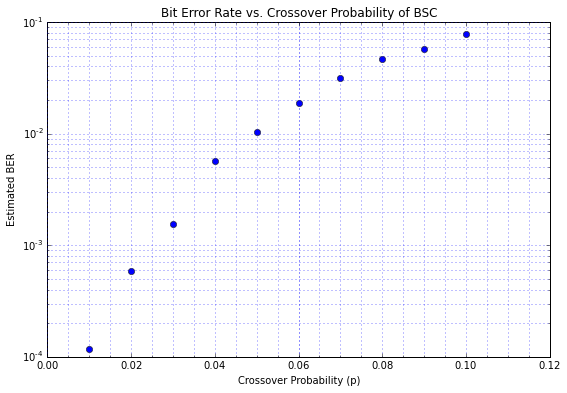

In [58]:
ps = np.linspace(0.01, 0.1, 10)
def ber_experiment(p, n_trials = 100, n_bits = 512, generators=example_generators):
    errors = 0
    for i in range(n_trials):
        bits_in = np.random.randint(0,1, 512)
        received = bsc(encode(bits_in, generators=generators), p=p)
        decoded = viterbi(received)
        errors += sum([bits_in[i]!=decoded[i] for i in range(len(bits_in))])
    return float(errors) / (n_bits * n_trials)
error_prob = [ber_experiment(p, generators=example_generators) for p in ps]

figure(figsize(9,6))
semilogy(ps, error_prob,'o')

plt.title('Bit Error Rate vs. Crossover Probability of BSC')
plt.xlabel('Crossover Probability (p)')
plt.ylabel('Estimated BER')

plt.minorticks_on()
plt.grid(b=True,which = 'both',color = 'b')

### (B) Assume we are communicating over a binary symmetric channel with $p =0.05$. Using our repetition encoder, what is the smallest number of repetitions $r$ we would need in order to achieve a superior BER to our convolutional code? Suppose the coded symbols are sent over a 10MHz wireless channel at the rate of $10\times10^6$ symbols/sec. Compare the data rate, in bits per second (bps), of the convolutional code and the repetition code for this value of $r$. Now suppose, $p=0.02$. What is the minimum $r$ we need to outperform convolutional encoding? How does the data rate compare now?

## <font color='red'> Solution
Based on our plots from 1(B) and 4(A) we observe that we'll need at least 3 repetitions in order to achieve a lower BER than we get from the convolutional code over a BSC with $p=0.05$. Since we are sending 2 bits for every one bit when we perform convolutional coding and 3 bits with repition coding, the convolutional code is a 50% improvement.

We'll need at least 5 repetitions for in the case where $p=0.02$ based on the plots. The convolutional code is a 150% speedup!